Accuracy, the most common evaluation metric might sometimes not be the best metric for evaluating a model. Imagine working with a binary classification data where 80% of the target variable belong to 1 20% to 0, predicting all the output as 1 gives an accuracy of 80% which is good accuracy score but not a good evaluation metric seeing it only predict a single class as it output. 

This notebook explain what evaluation metric means, List different types of evaluation metric for binary classification models and how to implement them from scratch(for better understanding) and using the scikit learn library.

What is Evaluation Metric?
Evaluation metrics are used to measure the quality of machine learning models. Evaluating machine learning models or algorithms is essential for any project.

There a lot of evaluation metrics in Machine Learning but for the scope of this writing we would cover few important ones;
1.	Accuracy
2.	Confusion matrix
3.	Precision and Recall
4.	F1 Score
5.	ROC Score Curve
6.	AUC score
7.	Cross Validation

In [1]:
#Implementing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

Loading Data

In [2]:
data = pd.read_csv("C:/Users/Godwin/Documents/Workflow/ML Zoomcamp/Classification/Customer-churn/Telco-Customer-Churn.csv")
data.columns = data.columns.str.replace(' ', '_').str.lower()

categorical_col = data.dtypes[data.dtypes == 'object'].index.tolist()

for col in categorical_col:
    data[col] = data[col].str.replace(' ', '_').str.lower()
data.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,no
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.5,no
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,...,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,yes
3,7795-cfocw,male,0,no,no,45,no,no_phone_service,dsl,yes,...,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,no
4,9237-hqitu,female,0,no,no,2,yes,no,fiber_optic,no,...,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,yes


Data Preparation

In [3]:
#Convering categorical to column to numerical
data['totalcharges'] = pd.to_numeric(data['totalcharges'], errors= 'coerce')

#Filling null values
data['totalcharges'].fillna(data['totalcharges'].mean(), inplace = True)

categorical_col = ['customerid','gender', 'partner', 'dependents',
                    'phoneservice', 'multiplelines', 'internetservice',
                    'onlinesecurity', 'onlinebackup', 'deviceprotection',
                    'techsupport', 'streamingtv', 'streamingmovies',
                    'contract', 'paperlessbilling', 'paymentmethod']

numerical_col = ['tenure', 'totalcharges', 'monthlycharges']

In [4]:
#Percentage of churning to not churning
(data['churn'].value_counts(normalize=True)*100).sort_values()

yes    26.536987
no     73.463013
Name: churn, dtype: float64

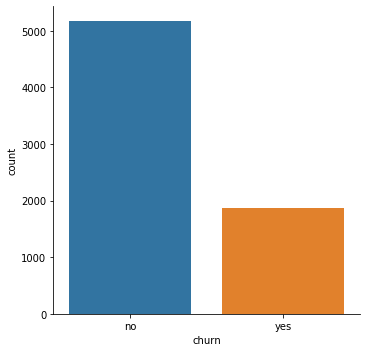

In [5]:
sns.catplot(x = 'churn', kind = 'count', data = data)

The data is highly imbalance withe 73.46% of the target belonging to No churn class and 26.53% belong to Churn.

In [6]:
#Covert churn column to integer
data['churn'] = (data.churn=='yes').astype(int)

#Spliting the data
train_df, test_df = train_test_split(data, test_size = 0.2, random_state=1)
train_df, val_df = train_test_split(train_df, test_size = 0.25, random_state=1)

y_train = train_df.pop('churn')
y_test = test_df.pop('churn')
y_val = val_df.pop('churn')

In [7]:
#Encoding the data with DictVectorizer
dv = DictVectorizer(sparse = False)

dv.fit(train_df[categorical_col + numerical_col].to_dict(orient = 'records'))
X_train = dv.transform(train_df[categorical_col + numerical_col].to_dict(orient = 'records'))
X_test =  dv.transform(test_df[categorical_col + numerical_col].to_dict(orient = 'records'))
X_val =  dv.transform(val_df[categorical_col + numerical_col].to_dict(orient = 'records'))

In [8]:
#Training the model
model = LogisticRegression()
model.fit(X_train, y_train)

#Model validation
prediction = model.predict_proba(X_val)[:,1]
churn_decision = (prediction >= 0.5)

Accuracy

In [9]:
#Checking accuracy of the model
print((y_val == churn_decision).mean())

0.7977288857345636


In [10]:
#Using Sklearn
accuracy_score(y_val, churn_decision)

0.7977288857345636

Confusion Matrix

In [11]:
#churn_decision = churn_decision.astype('int')
threshold = 0.5

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

predicted_positive = (prediction >= threshold)
predicted_negative = (prediction < threshold)



tp = (actual_positive & predicted_positive).sum()
tn = (actual_negative & predicted_negative).sum()
fp = (actual_negative & predicted_positive).sum()
fn = (actual_positive & predicted_negative).sum()

conf_mat = np.array([[tn,fp], [fn, tp]])

#Using Sklearn
out = confusion_matrix(y_val, churn_decision)

In [12]:
out

array([[914, 109],
       [176, 210]], dtype=int64)

In [13]:
conf_mat

array([[914, 109],
       [176, 210]], dtype=int64)

True Positive(TP): Values that were positive and predicted as positive
True Negative(TN): Values that were negative and predicted as negative
False Positive(FP): Values that are negative but predicted as positive
False Negative(FN): Values that are positive but predicted as negative

The confusion matrix shows the models; TP = 210,
                                       TN = 917,
                                       FN = 176,
                                       FP = 106.

Precision: 

Precision return how accurate the model is in its positive predictions. It tell what percentage of the of the positive prediction are actually positive.


In [14]:
precision = tp/ (tp + fp)

#Using Sklearn
sklearn_precision = precision_score(y_val, churn_decision)

In [15]:
precision

0.658307210031348

In [16]:
sklearn_precision

0.658307210031348

Recall

It is the ratio of the positive prediction to the total actual positive values.

In [17]:
recall = tp/ (tp + fn)

#Using Sklearn
sklearn_recall = recall_score(y_val, churn_decision)

In [18]:
recall

0.5440414507772021

In [19]:
sklearn_recall

0.5440414507772021

F1 Score

F1 Score sums up the predictive performance of a model by combining two other metrics(Precision and Recall).

F1 score combine the precision and recall metric together by taking their harmonic mean.

In [20]:
f1_score_normal = 2 * ((precision * recall)/ (precision + recall))

#Using Sklearn
sklearn_f1Score = f1_score(y_val, churn_decision.astype('int'))

In [21]:
f1_score_normal

0.5957446808510638

In [22]:
sklearn_f1Score

0.5957446808510638

ROC Curve and AUC Score

ROC Curve: ROC curve is a graph showing the performance of a classification model at all classification thresholds. The curve shows this performance using true positive rate and false positive rate of a model across different threshold.


AUC score: AUC stand for Area Under the Curve. This metric return the area under the ROC curve which represents the probability that the model ranks a random positive example more highly than a random negative example.

In [23]:
def model_rates(y_test, prediction):
        
    threshold = np.linspace(0, 1, 101)

    score = []
    for t in threshold:

        actual_positive = (y_test == 1)
        actual_negative = (y_test == 0)

        predicted_positive = (prediction >= t)
        predicted_negative = (prediction < t)

        tp = (actual_positive & predicted_positive).sum()
        tn = (actual_negative & predicted_negative).sum()
        fp = (actual_negative & predicted_positive).sum()
        fn = (actual_positive & predicted_negative).sum()

        tpr = tp/ (tp + fn)
        fpr = fp/ (fp + tn)


        score.append([t, tpr,fpr])

    df = pd.DataFrame(score, columns= ['Threshold','Tpr', 'Fpr'])
    return df

In [24]:
#Creating random prediction 
y_rand = np.random.uniform(0,1, size=len(y_val))
rand_df = model_rates(y_val, y_rand)

#Prediction
df = model_rates(y_val, prediction)

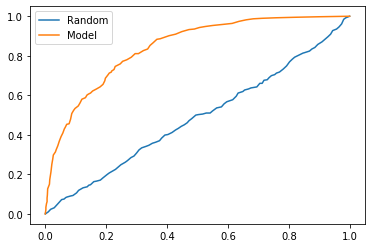

In [25]:
#Visualizing ROC curve

plt.plot(rand_df.Fpr, rand_df.Tpr, label = 'Random')
plt.plot(df.Fpr, df.Tpr, label = 'Model')
plt.legend()

In [26]:
auc_score = auc(df.Fpr, df.Tpr)
auc_score


0.8415687883346249

In [27]:
#Using Sklearn

fpr, tpr, thres = roc_curve(y_val, prediction)
auc_score = auc(fpr,tpr)
auc_score

0.8417992392587076

Cross Validation
Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample. The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. 

Cross validation trains the model on each split and validates its performance on the other splits. It then computes the mean of the model's performance after training and validating on all the splits.

In [28]:
#Function For Training
def train(data, y):
    dv.fit(data[categorical_col + numerical_col].to_dict(orient = 'records'))
    X_train = dv.transform(data[categorical_col + numerical_col].to_dict(orient = 'records'))

    model = LogisticRegression(C = 1, max_iter = 1000)
    model.fit(X_train, y)
    return dv, model

#Function for prediction
def predict(data, dv, model):
    X_test = dv.transform(data[categorical_col + numerical_col].to_dict(orient = 'records'))
    prediction = model.predict_proba(X_test)[:,1]
    return prediction


full_df = pd.concat([train_df,val_df])
full_df['label'] = (pd.concat([y_train,y_val]))

#Spliting Data
kfold = KFold(n_splits=10, shuffle= True, random_state=1)
train_idx, val_idx = next(kfold.split(full_df))

In [29]:
scores = []
for train_idx, val_idx in kfold.split(full_df):

    train_df = full_df.iloc[train_idx]
    val_df = full_df.iloc[val_idx]

    y_train = train_df.pop('label')
    y_val = val_df.pop('label')

    dv, model = train(train_df, y_train)
    prediction = predict(val_df, dv, model)

    auc = roc_auc_score(y_val, prediction)
    scores.append(round(auc, 3))

In [31]:
#Taking the mean of the training and validating on all split
np.mean(scores)

0.8422999999999998

In [32]:
np.std(scores)

0.015073486657041243

The standard deviation represents the deviation from the mean Auc score for all the split